# LSTM Regression

---

Aditya Marathe

## Imports

In [1]:
%matplotlib inline

import sys

import h5py
import pandas as pd

import numpy as np

from sklearn.preprocessing import StandardScaler

from tensorflow import keras

import matplotlib as mpl
import matplotlib.pyplot as plt

**Local**

In [2]:
sys.path.insert(1, './../')

import ana
from transforms import *

**Version and hardware**

In [3]:
print(f'Python {sys.version}\n')
print(f'H5Py {h5py.__version__}')
print(f'Pandas {pd.__version__}')
print(f'NumPy {np.__version__}')
print(f'Matplotlib {mpl.__version__}')

Python 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]

H5Py 3.10.0
Pandas 2.2.1
NumPy 1.26.4
Matplotlib 3.8.3


## Data

In [4]:
ds = ana.Datasets()

Datasets | Found the following: MINI_DATA_DIR, DATA_V2_DIR, DATA_V3_DIR, REALLY_MINI_DIR, COPYMERGED_C8_DIR, COPYMERGED_C9_DIR, COPYMERGED_C10_DIR, COPYMERGED_C11_DIR, COPYMERGED_C13_DIR, COPYMERGED_C15_DIR, COPYMERGED_C16_DIR, COPYMERGED_C17_DIR, COPYMERGED_C19_DIR, COPYMERGED_C20_DIR, COPYMERGED_C21_DIR, COPYMERGED_C22_DIR


In [5]:
data = ana.NOvAData.init_from_copymerge_h5(
    h5dirs=[
        ds.COPYMERGED_C8_DIR,  # type: ignore
        ds.COPYMERGED_C9_DIR,  # type: ignore
        ds.COPYMERGED_C10_DIR,  # type: ignore
        # ds.COPYMERGED_C11_DIR,  # type: ignore
        # ds.COPYMERGED_C13_DIR,  # type: ignore
        # ds.COPYMERGED_C15_DIR,  # type: ignore
        # ds.COPYMERGED_C16_DIR,  # type: ignore
        # ds.COPYMERGED_C17_DIR,  # type: ignore
        # ds.COPYMERGED_C19_DIR,  # type: ignore
        # ds.COPYMERGED_C20_DIR,  # type: ignore
        # ds.COPYMERGED_C21_DIR,  # type: ignore
        # ds.COPYMERGED_C22_DIR  # type: ignore
    ]
)

NOvAData | Loading tables from copymerged HDF5 files...
NOvAData | Loaded table from copymerged HDF5 files (1 / 3).
NOvAData | Loaded table from copymerged HDF5 files (2 / 3).
NOvAData | Loaded table from copymerged HDF5 files (3 / 3).
NOvAData | Initialised NOvAData(features=59, events=480_160).


In [6]:
data.fill_ana_flags(inplace=True)
data.fill_ana_track_kinematics(inplace=True)
data.fill_categorical(inplace=True)

NOvAData | Filled MC truth flags.
NOvAData | Filled track kinematics.
NOvAData | Filled categorical data.


In [7]:
cuts = ana.Cuts.init_nova_cuts()
cuts.print_all_cuts()

Defined Cuts
------------
	Detector Quality
	Data Quality
	CVN PID Score
	Containment
	Cosmic Rej.
	Veto


In [287]:
config = {
    'Cuts': [
        'Detector Quality',
        'Data Quality',
        'Cosmic Rej.',
        'Veto',
        'CVN PID Score'
        # 'Containment'
        'Not Containment'
    ],
    'Transforms': [
        'tf_290124_positive_energies',
        'tf_290124_valid_pid',
        'tf_050224_max_prongs',
        'tf_050224_add_padding',
        'tf_070324_only_signal_events'
    ],
    'XDataCols': [
        # Input 1
        # 'rec.trk.kalman.ntracks',
        # 'rec.trk.kalman.ntracks2d',

        'rec.trk.kalman.tracks.calE',
        # 'rec.trk.kalman.tracks.overlapE',

        'rec.trk.kalman.tracks.nplane',
        # 'rec.trk.kalman.tracks.maxplanecont',

        'rec.trk.kalman.tracks.nhit',
        'rec.trk.kalman.tracks.nhitx',
        'rec.trk.kalman.tracks.nhity',

        # 'rec.trk.kalman.tracks.dir.x',
        # 'rec.trk.kalman.tracks.dir.y',
        # 'rec.trk.kalman.tracks.dir.z',

        # 'rec.trk.kalman.tracks.start.x',
        # 'rec.trk.kalman.tracks.start.y',
        # 'rec.trk.kalman.tracks.start.z',

        'rec.trk.kalman.tracks.len',
        
        # 'rec.trk.kalman.tracks.muonid',
        # 'rec.trk.kalman.tracks.rempid',

        # Input 2
        'rec.slc.calE',
        'rec.slc.nhit',
        # 'rec.energy.numu.lstmnu',
        # 'rec.energy.numu.lstmmuon',
        'ana.trk.kalman.tracks.Pmu'
    ],
    'YDataCols': [
        'rec.mc.nu.E'
    ]
}

"""
rec.slc.nhit                      0.525513
rec.slc.calE                      0.508889
rec.trk.kalman.tracks.nplane.1    0.504116
rec.trk.kalman.tracks.calE.1      0.503850
rec.trk.kalman.tracks.len.1       0.499055
rec.trk.kalman.tracks.nhit.1      0.496424
rec.trk.kalman.tracks.nhity.1     0.486028
rec.trk.kalman.tracks.nhitx.1     0.484069
ana.trk.kalman.tracks.Pmu         0.482681
rec.trk.kalman.ntracks            0.240110
"""

'\nrec.slc.nhit                      0.525513\nrec.slc.calE                      0.508889\nrec.trk.kalman.tracks.nplane.1    0.504116\nrec.trk.kalman.tracks.calE.1      0.503850\nrec.trk.kalman.tracks.len.1       0.499055\nrec.trk.kalman.tracks.nhit.1      0.496424\nrec.trk.kalman.tracks.nhity.1     0.486028\nrec.trk.kalman.tracks.nhitx.1     0.484069\nana.trk.kalman.tracks.Pmu         0.482681\nrec.trk.kalman.ntracks            0.240110\n'

In [288]:
_col_names = (
    [
        'rec.trk.kalman.ntracks',
        'rec.trk.kalman.ntracks2d'
    ]
    + [
        f'rec.trk.kalman.tracks.calE.{i + 1}' for i in range(5)
    ]
    + [
        f'rec.trk.kalman.tracks.overlapE.{i + 1}' for i in range(5)
    ]
    + [
        f'rec.trk.kalman.tracks.nplane.{i + 1}' for i in range(5)
    ]
    + [
        f'rec.trk.kalman.tracks.maxplanecont.{i + 1}' for i in range(5)
    ]
    + [
        f'rec.trk.kalman.tracks.nhit.{i + 1}' for i in range(5)
    ]
    + [        
        f'rec.trk.kalman.tracks.nhitx.{i + 1}' for i in range(5)
    ]
    + [        
        f'rec.trk.kalman.tracks.nhity.{i + 1}' for i in range(5)
    ]
    + [
        f'rec.trk.kalman.tracks.dir.x.{i + 1}' for i in range(5)
    ]
    + [        
        f'rec.trk.kalman.tracks.dir.y.{i + 1}' for i in range(5)
    ]
    + [        
        f'rec.trk.kalman.tracks.dir.z.{i + 1}' for i in range(5)
    ]
    + [
        f'rec.trk.kalman.tracks.start.x.{i + 1}' for i in range(5)
    ]
    + [        
        f'rec.trk.kalman.tracks.start.y.{i + 1}' for i in range(5)
    ]
    + [        
        f'rec.trk.kalman.tracks.start.z.{i + 1}' for i in range(5)
    ]
    + [
        f'rec.trk.kalman.tracks.len.{i + 1}' for i in range(5)
    ]
    + [        
        f'rec.trk.kalman.tracks.muonid.{i + 1}' for i in range(5)
    ]
    + [        
        f'rec.trk.kalman.tracks.rempid.{i + 1}' for i in range(5)
    ]
    + [        
        'ana.trk.kalman.tracks.Pmu'
    ]
    + [
        'rec.slc.calE',
        'rec.slc.nhit'
    ]
)

In [289]:
len(_col_names)

85

In [290]:
# Cuts
data.table = cuts.apply_cuts(config['Cuts'][:-1], data.table)
data.table = cuts.apply_cut('Containment', data.table, passed=False)

Cuts     | Applied 'Detector Quality' cut (17_893 -> 17_893 events).
Cuts     | Applied 'Data Quality' cut (17_893 -> 17_893 events).
Cuts     | Applied 'Cosmic Rej.' cut (17_893 -> 17_893 events).
Cuts     | Applied 'Veto' cut (17_893 -> 17_893 events).
Cuts     | Applied 'Containment' cut (17_893 -> 17_893 events).


In [291]:
# Transforms
data.apply_transforms(config['Transforms'], inplace=True)

NOvAData | Applied a transform which cuts out the negative energies caused by issues with the reco. models.
NOvAData | Applied a transform which ensures that the PID score is between 0 and 1.
NOvAData | Applied a transform which limits the number of max prongs to a certain amount.


NOvAData | Applied a transform which adds padding ([0, 0, ...]) to make prong variables of equal length.
NOvAData | Applied a transform which only keeps the signal events.


In [292]:
data.table = data.table[data.table['rec.mc.nu.E'] <= 5]

In [293]:
fail_cont = cuts.apply_cut('Containment', data.table, passed=False)
pass_cont = cuts.apply_cut('Containment', data.table)

Cuts     | Applied 'Containment' cut (17_893 -> 17_893 events).
Cuts     | Applied 'Containment' cut (17_893 -> 0 events).


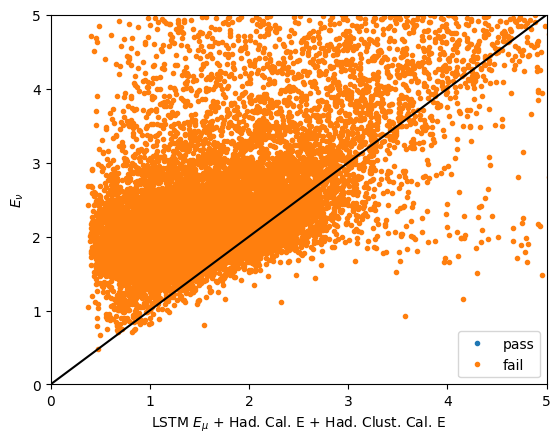

In [294]:
plt.plot(
    pass_cont['rec.energy.numu.lstmmuon'] + pass_cont['rec.energy.numu.hadcalE'] + pass_cont['rec.energy.numu.hadclust.calE'],
    pass_cont['rec.mc.nu.E'],
    '.',
    label='pass'
)
plt.plot(
    (
        fail_cont['rec.energy.numu.lstmmuon'] 
        + fail_cont['rec.energy.numu.hadcalE'] 
        + fail_cont['rec.energy.numu.hadclust.calE']
    ),
    fail_cont['rec.mc.nu.E'],
    '.',
    label='fail'
)
plt.plot([0, 5], [0, 5], 'k-')
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel(r'LSTM $E_\mu$ + Had. Cal. E + Had. Clust. Cal. E')
plt.ylabel(r'$E_\nu$')
plt.legend();

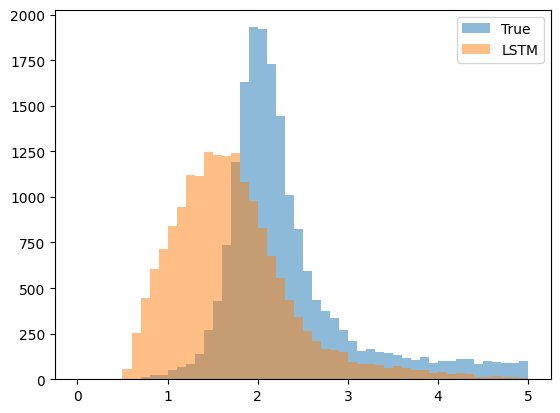

In [295]:
plt.hist(
    data.table['rec.mc.nu.E'],
    bins=np.linspace(0, 5, 50 + 1),
    alpha=0.5,
    label='True'
)
plt.hist(
    data.table['rec.energy.numu.lstmnu'],
    bins=np.linspace(0, 5, 50 + 1),
    alpha=0.5,
    label='LSTM'
)
plt.legend();

In [296]:
np.sqrt(np.mean((1 - (data.table['rec.energy.numu.lstmnu'] / data.table['rec.mc.nu.E']))**2))

0.36376831115153924

In [297]:
"""
x_data = [
	# Old EE
	# 'rec.energy.numu.E',
	# 'rec.energy.numu.recomuonE',
	# 'rec.energy.numu.calccE',
	# 'rec.energy.numu.trkccE',

	# New LSTM EE
	# 'rec.energy.numu.lstmmuon',
	# 'rec.energy.numu.lstmnu',

	# Hadronic stuff
	'rec.energy.numu.hadcalE',
	'rec.energy.numu.hadtrkE',
	'rec.energy.numu.hadclust.calE',
	# 'rec.energy.numu.regcvnhadE',
	'rec.energy.numu.hadclust.nhit',

	# Slice
	'rec.slc.calE',
	'rec.slc.nhit',
	# 'rec.slc.firstplane',
	# 'rec.slc.lastplane',
	# 'rec.slc.ncontplanes',

	# Kalman tracks (const. len.)
	'rec.trk.kalman.ntracks',
	'rec.trk.kalman.ntracks2d',

	# Kalman tracks (varying len.)
	'rec.trk.kalman.tracks.calE',
	'rec.trk.kalman.tracks.overlapE',

	'rec.trk.kalman.tracks.nplane',
	'rec.trk.kalman.tracks.maxplanecont',

	'rec.trk.kalman.tracks.nhit',
	'rec.trk.kalman.tracks.nhitx',
	'rec.trk.kalman.tracks.nhity',

	'rec.trk.kalman.tracks.dir.x',
	'rec.trk.kalman.tracks.dir.y',
	'rec.trk.kalman.tracks.dir.z',
	'rec.trk.kalman.tracks.start.x',
	'rec.trk.kalman.tracks.start.y',
	'rec.trk.kalman.tracks.start.z',

	'rec.trk.kalman.tracks.len',

	'rec.trk.kalman.tracks.muonid',
	'rec.trk.kalman.tracks.rempid',

	# Kalman track (derived)
	# 'ana.trk.kalman.tracks.cosBeam',
	'ana.trk.kalman.tracks.PtToPmu',
	# 'ana.trk.kalman.tracks.Pmu',
	# 'ana.trk.kalman.tracks.Pt',
	# 'ana.trk.kalman.tracks.Qsquared',
	# 'ana.trk.kalman.tracks.W',  --> Too many NaNs
]
"""

x_data = config['XDataCols']

y_data = config['YDataCols']

In [298]:
# Flatten the data
numpy_table_x = np.vstack(
    data.table[x_data].apply(lambda row: np.hstack(row), axis=1).to_numpy()  # type: ignore
)
numpy_table_y = data.table[y_data].to_numpy().flatten()

In [299]:
# pd.DataFrame(data=numpy_table_x, columns=_col_names).corrwith(
#     pd.Series(numpy_table_y)
# ).nlargest(10)

In [300]:
n = len(numpy_table_x)

In [301]:
# Train test split
train_x = numpy_table_x[:int(n * 0.8)]
train_y = numpy_table_y[:int(n * 0.8)]

test_x = numpy_table_x[int(n * 0.8):]
test_y = numpy_table_y[int(n * 0.8):]

In [302]:
std_scaler_input = StandardScaler()
train_x = std_scaler_input.fit_transform(train_x)
test_x = std_scaler_input.transform(test_x)

In [303]:
std_scaler_output = StandardScaler()
train_y = std_scaler_output.fit_transform(train_y.reshape(-1, 1))
test_y = std_scaler_output.transform(test_y.reshape(-1, 1))

## Model

In [406]:
binning = np.linspace(0, 5, 50 + 1)

In [407]:
values, edges = np.histogram(
    data.table['rec.mc.nu.E'],
    bins=binning
)

In [495]:
bin_weights = 1 - np.log(1 + (values / (values.max())))
# bin_weights[:15] = bin_weights[:15] * 3

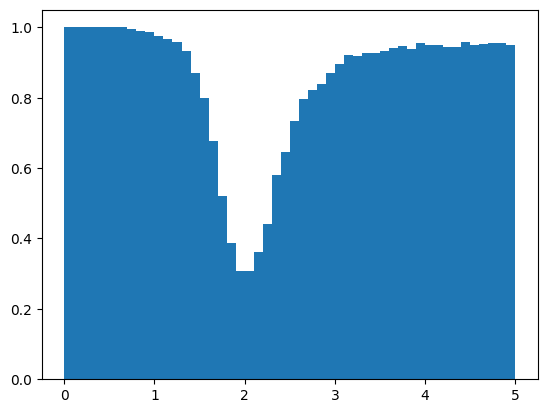

In [496]:
plt.hist(
    binning[:-1],
    bins=binning,
    weights=bin_weights
);
# plt.yscale('log');

In [497]:
bin_num = np.digitize(
    data.table['rec.mc.nu.E'],
    bins=binning
)

In [498]:
weights = np.zeros(data.table['rec.mc.nu.E'].shape)

In [499]:
for i in range(len(binning) - 1):
    weights[np.where(bin_num == i)] = bin_weights[i]

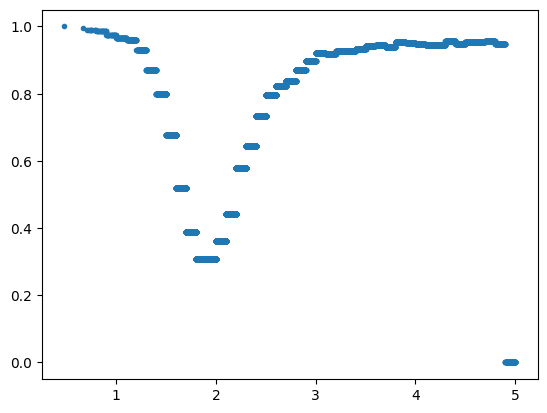

In [500]:
plt.plot(data.table['rec.mc.nu.E'], weights, '.');

In [501]:
def build_compile_model_2(input_shape):
    model = keras.Sequential(
        layers=[
            keras.layers.Input(
                shape=input_shape,
                name='input'
            ),
            keras.layers.BatchNormalization(
                name='batchnorm-1'
            ),
            keras.layers.Dense(
                units=128,
                activation=keras.activations.relu,
                name='dense-1'
            ),
            keras.layers.BatchNormalization(
                name='batchnorm-2'
            ),
            keras.layers.Dense(
                units=64,
                activation=keras.activations.relu,
                name='dense-2'
            ),
            keras.layers.BatchNormalization(
                name='batchnorm-3'
            ),
            keras.layers.Dense(
                units=64,
                activation=keras.activations.relu,
                name='dense-3'
            ),
            keras.layers.BatchNormalization(
                name='batchnorm-4'
            ),
            keras.layers.Dense(
                units=16,
                activation=keras.activations.relu,
                name='dense-4'
            ),
            keras.layers.BatchNormalization(
                name='batchnorm-5'
            ),
            keras.layers.Dense(
                units=16,
                activation=keras.activations.relu,
                name='dense-5'
            ),
            keras.layers.Dropout(
                0.5
            ),
            keras.layers.BatchNormalization(
                name='batchnorm-6'
            ),
            keras.layers.Dense(
                units=8,
                activation=keras.activations.relu,
                name='dense-6'
            ),
            keras.layers.Dense(
                units=1, 
                activation=keras.activations.linear,
                name='output'
            )
        ]
        
    )

    # Compile
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1E-3),
        loss=keras.losses.mean_squared_error,
        weighted_metrics=[
            keras.metrics.MeanSquaredError(name='mse'),
            keras.metrics.MeanAbsoluteError(name='mae')
        ]
    )

    return model


In [502]:
def build_compile_model(
        input_1_shape,
        input_2_shape,
    ) -> keras.models.Model:
    # Branch #1
    branch_1_input = keras.layers.Input(
        shape=input_1_shape,
        name='input-1'
    )

    # Pre-processing (Branch #1)
    branch_1 = keras.layers.BatchNormalization(
        name='batch-norm-1-1'
    )(branch_1_input)
    branch_1 = keras.layers.Dense(
        units=128, 
        activation=keras.activations.relu,
        name='dense-1-1'
    )(branch_1)
    branch_1 = keras.layers.BatchNormalization(name='batch-norm-1-2')(branch_1)
    branch_1 = keras.layers.Dense(
        units=128, 
        activation=keras.activations.relu,
        name='dense-1-2'
    )(branch_1)
    branch_1 = keras.layers.BatchNormalization(name='batch-norm-1-3')(branch_1)
    branch_1 = keras.layers.Dense(
        units=128, 
        activation=keras.activations.relu,
        name='dense-1-3'
    )(branch_1)
    branch_1 = keras.layers.BatchNormalization(name='batch-norm-1-4')(branch_1)
    
    # LSTM
    branch_1 = keras.layers.Reshape((1, 128))(branch_1)
    branch_1 = keras.layers.LSTM(32, name='lstm')(branch_1)

    # Branch #2
    branch_2_input = keras.layers.Input(shape=input_2_shape, name='input-2')
    # branch_2_input = keras.layers.Reshape((3,))(branch_2_input)

    branch_concat = keras.layers.concatenate([branch_1, branch_2_input])

    # Post-processing (Branch #3)
    branch_concat = keras.layers.BatchNormalization(
        name='batch-norm-3-1'
    )(branch_concat)
    branch_concat = keras.layers.Dense(
        units=128,
        activation=keras.activations.relu,
        name='dense-3-1'
    )(branch_concat)
    branch_concat = keras.layers.BatchNormalization(
        name='batch-norm-3-2'
    )(branch_concat)
    branch_concat = keras.layers.Dense(
        units=128, 
        activation=keras.activations.relu,
        name='dense-3-2'
    )(branch_concat)
    branch_concat = keras.layers.BatchNormalization(
        name='batch-norm-3-3'
    )(branch_concat)
    branch_concat = keras.layers.Dense(
        units=128, 
        activation=keras.activations.relu,
        name='dense-3-3'
    )(branch_concat)
    branch_concat = keras.layers.BatchNormalization(
        name='batch-norm-3-4'
    )(branch_concat)

    # Output
    output = keras.layers.Dense(
        units=1, 
        activation=keras.activations.linear
    )(branch_concat)

    # Model
    model = keras.models.Model(
        name='model',
        inputs=[branch_1_input, branch_2_input],
        outputs=output
    )

    # Compile
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1E-3),
        loss=keras.losses.mean_squared_error,
        weighted_metrics=[
            keras.metrics.MeanSquaredError(name='mse'),
            keras.metrics.MeanAbsoluteError(name='mae')
        ]
    )

    return model


In [503]:
def build_compile_model_new(
        input_1_shape,
        input_2_shape,
        # Settings
        learning_rate=1E-3,
        n_preprocessing = 3,
        n_postprocessing = 3
    ) -> keras.models.Model:
    # Branch #1
    branch_1_input = keras.layers.Input(
        shape=input_1_shape,
        name='input-1-1'
    )

    # Pre-processing
    for layer_n in range(n_preprocessing):
        branch_1 = keras.layers.BatchNormalization(
            name=f'batch-norm-1-{layer_n + 1}'
        )(branch_1 if layer_n else branch_1_input)
        branch_1 = keras.layers.Dense(
            units=128, 
            activation=keras.activations.relu,
            name=f'dense-1-{layer_n + 1}'
        )(branch_1)

    branch_1 = keras.layers.BatchNormalization(
        name=f'batch-norm-1-{layer_n + 2}'
    )(branch_1)
    # branch_1 = keras.layers.Dropout(
    #     rate=0.3,
    #     name='dropout-1-1'
    # )(branch_1)
    
    # LSTM
    branch_1 = keras.layers.Reshape((1, 128))(branch_1)
    branch_1 = keras.layers.LSTM(32, name='lstm')(branch_1)

    # Branch #2
    branch_2_input = keras.layers.Input(shape=input_2_shape, name='input-2')
    # branch_2_input = keras.layers.Reshape((3,))(branch_2_input)

    branch_concat = keras.layers.concatenate([branch_1, branch_2_input])

    # Post-processing
    for layer_n in range(n_postprocessing):
        branch_concat = keras.layers.BatchNormalization(
            name=f'batch-norm-3-{layer_n + 1}'
        )(branch_concat)
        branch_concat = keras.layers.Dense(
            units=128, 
            activation=keras.activations.relu,
            name=f'dense-3-{layer_n + 1}'
        )(branch_concat)

    branch_concat = keras.layers.BatchNormalization(
        name=f'batch-norm-3-{layer_n + 2}'
    )(branch_concat)

    # Some information dropout...

    # branch_concat = keras.layers.Dropout(
    #     rate=0.1,
    #     name='dropout-3-1'
    # )(branch_concat)

    # Reduce dimensions...

    branch_concat = keras.layers.Dense(
        units=64, 
        activation=keras.activations.relu,
        name=f'dense-3-{layer_n + 2}'
    )(branch_concat)
    branch_concat = keras.layers.Dense(
        units=16, 
        activation=keras.activations.relu,
        name=f'dense-3-{layer_n + 3}'
    )(branch_concat)
    branch_concat = keras.layers.Dense(
        units=8, 
        activation=keras.activations.relu,
        name=f'dense-3-{layer_n + 4}'
    )(branch_concat)

    # Output
    output = keras.layers.Dense(
        units=1, 
        activation=keras.activations.linear,
        name='output'
    )(branch_concat)

    # Model
    model = keras.models.Model(
        name='model',
        inputs=[branch_1_input, branch_2_input],
        outputs=output
    )

    # Compile
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=learning_rate,
            name='adam'
        ),
        loss=keras.losses.MeanSquaredError(name='loss'),
        weighted_metrics=[
            keras.metrics.MeanSquaredError(name='mse'),
            keras.metrics.MeanAbsoluteError(name='mae')
        ]
    )

    return model


In [504]:
class TransformerEncoderLayer(keras.layers.Layer):
    def __init__(
            self,
            embed_dim,
            num_heads,
            ff_dim,
            output_shape=None,
            rate=0.1
        ):
        super().__init__(name='transformer-encoder')
        self.att = keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim,
            output_shape=output_shape
        )
        self.ffn = keras.Sequential(
            [
                keras.layers.Dense(ff_dim, activation="relu"),
                keras.layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)  # self-attention layer
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # layer norm
        ffn_output = self.ffn(out1)  #feed-forward layer
        ffn_output = self.dropout2(ffn_output, training=training)
    
        return self.layernorm2(out1 + ffn_output)  # layer norm

In [505]:
def build_compile_transformer_v1(
        input_1_shape,
        input_2_shape,
        # Settings
        learning_rate=1E-3,
        n_preprocessing = 3,
        n_postprocessing = 3
    ) -> keras.models.Model:
    # Branch #1
    branch_1_input = keras.layers.Input(
        shape=input_1_shape,
        name='input-1-1'
    )

    # Pre-processing
    for layer_n in range(n_preprocessing):
        branch_1 = keras.layers.BatchNormalization(
            name=f'batch-norm-1-{layer_n + 1}'
        )(branch_1 if layer_n else branch_1_input)
        branch_1 = keras.layers.Dense(
            units=128, 
            activation=keras.activations.relu,
            name=f'dense-1-{layer_n + 1}'
        )(branch_1)

    branch_1 = keras.layers.BatchNormalization(
        name=f'batch-norm-1-{layer_n + 2}'
    )(branch_1)

    # Transformer
    branch_1 = keras.layers.Reshape((1, 128))(branch_1)
    # branch_1 = keras.layers.LSTM(32, name='lstm')(branch_1)
    branch_1 = TransformerEncoderLayer(
        embed_dim=128, num_heads=2, ff_dim=32
    )(branch_1)
    branch_1 = keras.layers.Reshape((128,))(branch_1)

    # Branch #2
    branch_2_input = keras.layers.Input(shape=input_2_shape, name='input-2')
    # branch_2_input = keras.layers.Reshape((3,))(branch_2_input)

    branch_concat = keras.layers.concatenate([branch_1, branch_2_input])

    # Post-processing
    for layer_n in range(n_postprocessing):
        branch_concat = keras.layers.BatchNormalization(
            name=f'batch-norm-3-{layer_n + 1}'
        )(branch_concat)
        branch_concat = keras.layers.Dense(
            units=128, 
            activation=keras.activations.relu,
            name=f'dense-3-{layer_n + 1}'
        )(branch_concat)

    branch_concat = keras.layers.BatchNormalization(
        name=f'batch-norm-3-{layer_n + 2}'
    )(branch_concat)

    # Reduce dimensions...
    branch_concat = keras.layers.Dense(
        units=64, 
        activation=keras.activations.relu,
        name=f'dense-3-{layer_n + 2}'
    )(branch_concat)
    branch_concat = keras.layers.Dense(
        units=16, 
        activation=keras.activations.relu,
        name=f'dense-3-{layer_n + 3}'
    )(branch_concat)
    branch_concat = keras.layers.Dense(
        units=8, 
        activation=keras.activations.relu,
        name=f'dense-3-{layer_n + 4}'
    )(branch_concat)

    # Output
    output = keras.layers.Dense(
        units=1, 
        activation=keras.activations.linear,
        name='output'
    )(branch_concat)

    # Model
    model = keras.models.Model(
        name='model',
        inputs=[branch_1_input, branch_2_input],
        outputs=output
    )

    # Compile
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=learning_rate,
            name='adam'
        ),
        loss=keras.losses.MeanSquaredError(name='loss'),
        weighted_metrics=[
            keras.metrics.MeanSquaredError(name='mse'),
            keras.metrics.MeanAbsoluteError(name='mae')
        ]
    )

    return model


In [506]:
model = build_compile_transformer_v1(
    input_1_shape=(train_x.shape[1] - 3,),
    input_2_shape=(3,),
    learning_rate=1E-4,
    n_postprocessing=5
)

In [507]:
epochs = 100

In [508]:
history = model.fit(
    [
        train_x[:, :train_x.shape[1] - 3],
        train_x[:, train_x.shape[1] - 3:]
    ],
    train_y,
    validation_split=0.2,

    sample_weight=weights,
    
    epochs=epochs,

    # callbacks=[
    #     keras.callbacks.EarlyStopping(
    #         monitor='val_loss',
    #         patience=20,
    #         restore_best_weights=True
    #     )
    # ]
)

In [ ]:
# model = build_compile_model_2(train_x.shape[1])

In [ ]:
"""
history = model.fit(
    train_x,
    train_y,
    sample_weight=weights,
    epochs=epochs,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=10,
            restore_best_weights=True
        )
    ]
)
""";

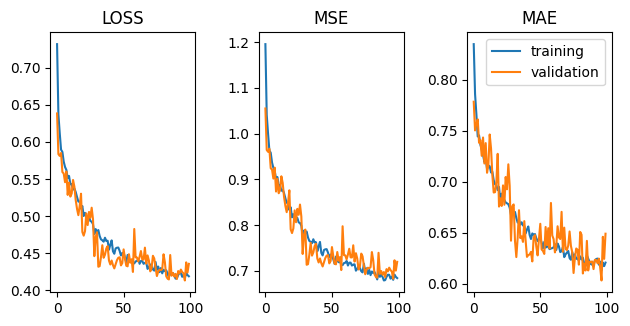

In [ ]:
fig, axs = plt.subplots(1, 3)

h_dict = history.history

actual_epochs = len(h_dict['loss'])
actual_epochs_list = list(range(actual_epochs))

stuff = ['loss', 'mse', 'mae']

for i, thing in enumerate(stuff):
    axs[i].plot(actual_epochs_list, h_dict[thing], label='training')
    axs[i].plot(actual_epochs_list, h_dict['val_' + thing], label='validation')
    axs[i].set_title(thing.upper())

axs[i].legend()

fig.tight_layout(rect=(0, 0, 1., 0.7))

## Testing

In [ ]:
import labbook
# labbook.load_last_model()

In [ ]:
prediction = model.predict(
    [
        test_x[:, :train_x.shape[1] - 3],
        test_x[:, train_x.shape[1] - 3:]
    ]
)
# prediction = model.predict(test_x)

112/112 [==============================] - 1s 6ms/step


In [ ]:
t_test_y = std_scaler_output.inverse_transform(test_y)
t_prediction = std_scaler_output.inverse_transform(prediction)

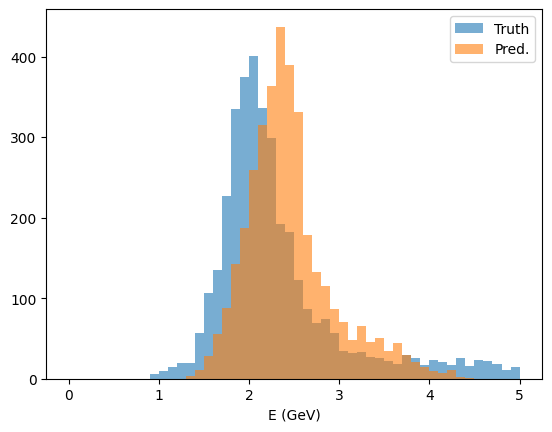

In [ ]:
plt.hist(
    t_test_y.flatten(),
    bins=np.linspace(0, 5, 50 + 1),
    alpha=0.6,
    label='Truth'
)
plt.hist(
    t_prediction.flatten(),
    bins=np.linspace(0, 5, 50 + 1),
    alpha=0.6,
    label='Pred.'
)
plt.xlabel('E (GeV)')
plt.legend();

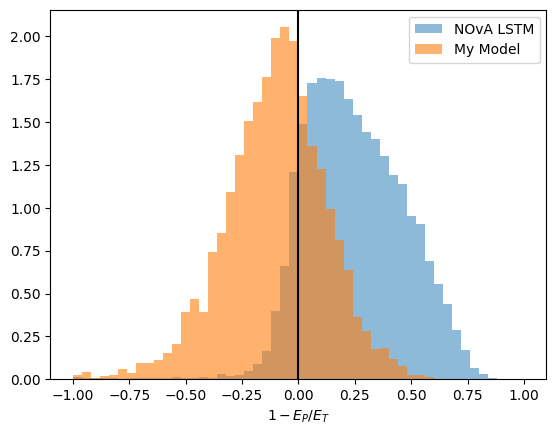

In [ ]:
plt.hist(
    1 - (data.table['rec.energy.numu.lstmnu'] / data.table['rec.mc.nu.E']),
    # 1 - (fail_cont['rec.energy.numu.lstmnu'] / fail_cont['rec.mc.nu.E']),
    bins=np.linspace(-1, 1, 50 + 1),
    alpha=0.5,
    density=True,
    label='NOvA LSTM'
)
plt.hist(
    1 - (t_prediction.flatten() / t_test_y.flatten()),
    bins=np.linspace(-1, 1, 50 + 1),
    alpha=0.6,
    density=True,
    label='My Model'
)
plt.axvline(0, color='k')
plt.xlabel('$1 - E_P / E_T$')
plt.legend();

In [ ]:
np.sqrt(np.mean((1 - (data.table['rec.energy.numu.lstmnu'] / data.table['rec.mc.nu.E']))**2))

0.36376831115153924

In [ ]:
np.sqrt(np.mean((1 - (t_prediction.flatten() / t_test_y.flatten()))**2))

0.2529120615669954

In [ ]:
which_bin = np.digitize(t_test_y.flatten(), bins=np.linspace(0, 5, 50 + 1))

In [ ]:
dist = 1 - (t_prediction.flatten() / t_test_y.flatten())

In [ ]:
dist_2 = 1 - (data.table['rec.energy.numu.lstmnu'] / data.table['rec.mc.nu.E']).to_numpy()

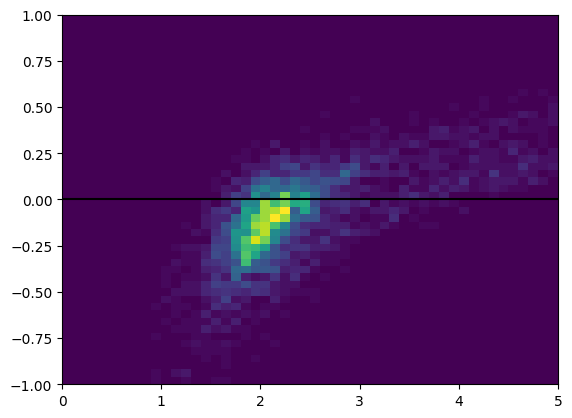

In [ ]:
bins = np.linspace(-1, 1, 50 + 1)

v, *_ = plt.hist2d(
    t_test_y.flatten(),
    1 - (t_prediction.flatten() / t_test_y.flatten()),
    bins=[np.linspace(0, 5, 50 + 1), bins]
)
plt.axhline(0, color='k')
plt.ylim(-1, 1)
plt.xlim(0, 5);

In [ ]:
bin_cents = (bins[:-1] + bins[1:]) / 2

In [ ]:
mean_v = []
rms_v = []
mean_v_2 = []
rms_v_2 = []

for i in range(50):
    bin_slice = dist[np.where(which_bin == i)]
    bin_slice_2 = dist_2[np.where(which_bin == i)]

    if len(bin_slice):
        mean_v.append(np.mean(bin_slice))
        rms_v.append(np.sqrt(np.mean(bin_slice**2)))
    else:
        mean_v.append(0)
        rms_v.append(0)

    if len(bin_slice_2):
        mean_v_2.append(np.mean(bin_slice_2))
        rms_v_2.append(np.sqrt(np.mean(bin_slice_2**2)))
    else:
        mean_v_2.append(0)
        rms_v_2.append(0)


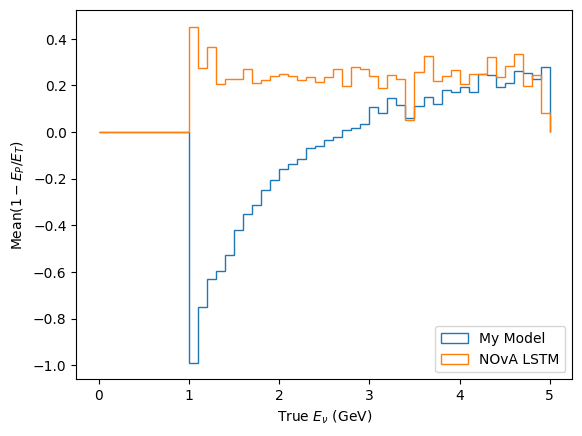

In [ ]:
plt.hist(
    np.linspace(0, 5, 50 + 1)[:-1],
    bins=np.linspace(0, 5, 50 + 1),
    weights=mean_v,
    histtype='step',
    label='My Model'
)
plt.hist(
    np.linspace(0, 5, 50 + 1)[:-1],
    bins=np.linspace(0, 5, 50 + 1),
    weights=mean_v_2,
    histtype='step',
    label='NOvA LSTM'
)
plt.legend()
plt.ylabel(r'Mean($1 - E_P / E_T$)')
plt.xlabel(r'True $E_\nu$ (GeV)');

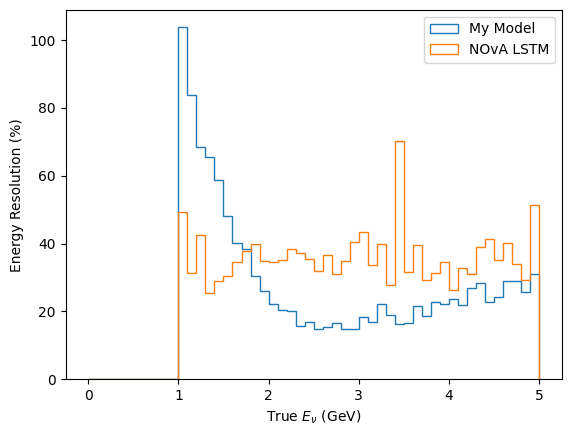

In [ ]:
plt.hist(
    np.linspace(0, 5, 50 + 1)[:-1],
    bins=np.linspace(0, 5, 50 + 1),
    weights=np.asarray(rms_v) * 100,
    histtype='step',
    label='My Model'
)
plt.hist(
    np.linspace(0, 5, 50 + 1)[:-1],
    bins=np.linspace(0, 5, 50 + 1),
    weights=np.asarray(rms_v_2) * 100,
    histtype='step',
    label='NOvA LSTM'
)
plt.legend()
plt.ylabel('Energy Resolution (%)')
plt.xlabel(r'True $E_\nu$ (GeV)');

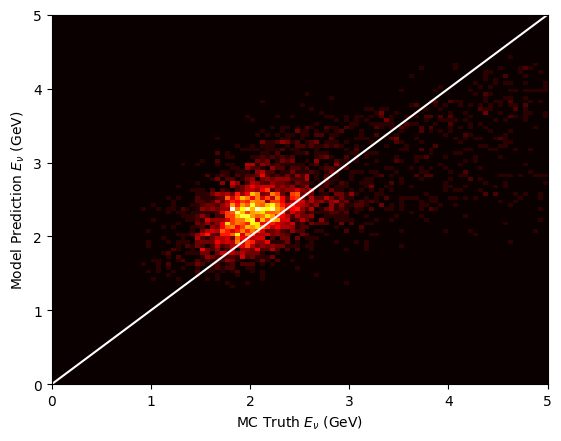

In [ ]:
plt.hist2d(
    t_test_y.flatten(),
    t_prediction.flatten(),
    bins=np.linspace(0, 5, 100 + 1),
    cmap='hot'
)
plt.plot([0, 5], [0, 5], 'w-')
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel(r'MC Truth $E_\nu$ (GeV)')
plt.ylabel(r'Model Prediction $E_\nu$ (GeV)');

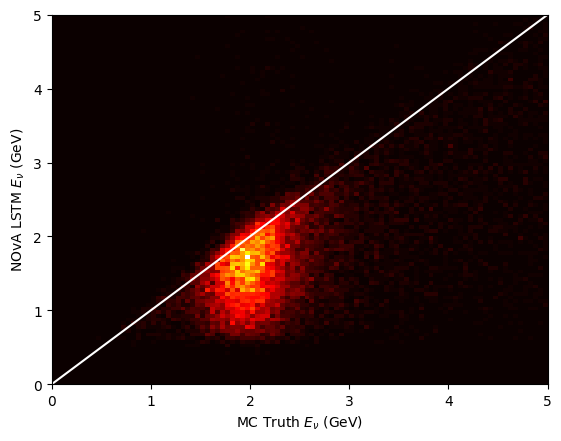

In [ ]:
plt.hist2d(
    data.table['rec.mc.nu.E'],
    data.table['rec.energy.numu.lstmnu'],
    bins=np.linspace(0, 5, 100 + 1),
    cmap='hot'
)
plt.plot([0, 5], [0, 5], 'w-')
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel(r'MC Truth $E_\nu$ (GeV)')
plt.ylabel(r'NOvA LSTM $E_\nu$ (GeV)');

In [ ]:
comments="""\
Regressor: LSTM
---------------


Code
----

def build_compile_model(
        input_1_shape,
        input_2_shape,
    ) -> keras.models.Model:
    # Branch #1
    branch_1_input = keras.layers.Input(shape=input_1_shape)

    # Pre-processing
    branch_1 = keras.layers.BatchNormalization()(branch_1_input)
    branch_1 = keras.layers.Dense(
        units=128, 
        activation=keras.activations.relu
    )(branch_1)
    branch_1 = keras.layers.BatchNormalization()(branch_1)
    branch_1 = keras.layers.Dense(
        units=128, 
        activation=keras.activations.relu
    )(branch_1)
    branch_1 = keras.layers.BatchNormalization()(branch_1)
    branch_1 = keras.layers.Dense(
        units=128, 
        activation=keras.activations.relu
    )(branch_1)
    branch_1 = keras.layers.BatchNormalization()(branch_1)
    
    # LSTM
    branch_1 = keras.layers.Reshape((1, 128))(branch_1)
    branch_1 = keras.layers.LSTM(32)(branch_1)

    # Branch #2
    branch_2_input = keras.layers.Input(shape=input_2_shape)
    # branch_2_input = keras.layers.Reshape((3,))(branch_2_input)

    branch_concat = keras.layers.concatenate([branch_1, branch_2_input])

    # Post-processing
    branch_concat = keras.layers.BatchNormalization()(branch_concat)
    branch_concat = keras.layers.Dense(
        units=128, 
        activation=keras.activations.relu
    )(branch_concat)
    branch_concat = keras.layers.BatchNormalization()(branch_concat)
    branch_concat = keras.layers.Dense(
        units=128, 
        activation=keras.activations.relu
    )(branch_concat)
    branch_concat = keras.layers.BatchNormalization()(branch_concat)
    branch_concat = keras.layers.Dense(
        units=128, 
        activation=keras.activations.relu
    )(branch_concat)
    branch_concat = keras.layers.BatchNormalization()(branch_concat)

    # Output
    output = keras.layers.Dense(
        units=1, 
        activation=keras.activations.linear
    )(branch_concat)

    # Model
    model = keras.models.Model(
        name='model',
        inputs=[branch_1_input, branch_2_input],
        outputs=output
    )

    # Compile
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1E-3),
        loss=keras.losses.mean_squared_error,
        weighted_metrics=[
            keras.metrics.MeanSquaredError(name='mse'),
            keras.metrics.MeanAbsoluteError(name='mae')
        ]
    )

    return model

"""

In [ ]:
# labbook.add_log_tf(
#     comments=comments,
#     config_dict=config,
#     train_history=history,
#     model=model,
#     lb_dir='./../../labbook',
#     seralise_objects={
#         'StandardScalerInput': std_scaler_input,
#         'StandardScalerOutput': std_scaler_output
#     }
# )